In [9]:
import cv2
import matplotlib.pyplot as plt
from lib_detection import load_model, detect_lp, im2single
img_path = "test.jpg"

In [10]:
wpod_net_path = "wpod-net_update1.json"
wpod_net = load_model(wpod_net_path)

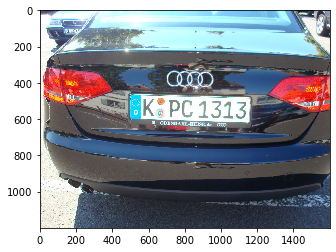

In [11]:
Ivehicle = plt.imread("detection_test.jpg")
plt.imshow(Ivehicle)


In [17]:
Dmax = 608
Dmin = 288

ratio = float(max(Ivehicle.shape[:2])) / min(Ivehicle.shape[:2])
side = int(ratio * Dmin)
bound_dim = min(side, Dmax)

_ , LpImg, lp_type = detect_lp(wpod_net, im2single(Ivehicle), bound_dim, lp_threshold=0.5)

print("Detect %i plate(s)"%len(LpImg))

(24, 32, 8)
Detect 1 plate(s)


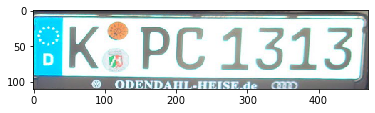

In [18]:
plt.imshow(LpImg[0])